# GRU Classifier

In [2]:
%load_ext autoreload
%autoreload 2

In [26]:
import sys
import time
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import sentencepiece as spm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("scripts")
from scripts.steam_review_dataset import SteamReviewDataset

In [4]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

In [6]:
# Lade die Daten
df = pd.read_csv("../data/reviews_100k_cleaned_new.csv.bz2")


# Aufteilen in Train+Validation und Test (80/20 Split)
train_val_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["voted_up"]
)

# Aufteilen von Train+Validation in Training und Validation (75/25 von Train+Val)
train_df, val_df = train_test_split(
    train_val_df, test_size=0.25, random_state=42, stratify=train_val_df["voted_up"]
)

# Überprüfe die Größe der Splits
print(f"Original size: {len(df)}")
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Original size: 94079
Train size: 56447
Validation size: 18816
Test size: 18816


In [7]:
# Erstelle Dataset-Objekte
tokenizer = spm.SentencePieceProcessor(model_file="../data/reviews_unigram.model")
max_len = 200  # 91% der Reviews haben weniger als 200 Tokens
batch_size = 32

train_dataset = SteamReviewDataset(data=train_df, tokenizer=tokenizer, max_len=max_len)
val_dataset = SteamReviewDataset(data=val_df, tokenizer=tokenizer, max_len=max_len)
test_dataset = SteamReviewDataset(data=test_df, tokenizer=tokenizer, max_len=max_len)

# Erstelle DataLoader für jeden Split
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Batch Shape
for tokens, labels in train_loader:
    print(f"Tokens shape: {tokens.shape}, Labels shape: {labels.shape}")
    break

print(train_dataset[0])

Tokens shape: torch.Size([32, 200]), Labels shape: torch.Size([32])
(tensor([ 101,  126, 1071,   18,    9,  626, 1013,   25,  574,   24,    4,  820,
        2099,   12,   36,    6,  202,  893,    7,   54,  519,  434,  454,  401,
         259,  931,  862,   22,   10,   23,   28,  703,   27, 1411,  142,  198,
          61,   86, 2311,   32,   62, 1029,  192,    6,   31,  452,    4,  246,
         110,   62,  198,  141,  174,  123,  142,  226,  180,  196,  250,   12,
        1593,  401, 1648,   32,  216,  625, 2085,  297,  862,   54,  519,  434,
          39,   12,    4,  387,   32,   89,   69,   85,   18,   19,  273,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  

In [8]:
class GRUClassifier(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        gru_layers: int,
        hidden_dim: int,
        dropout: float,
        output_dim: int,
        pad_idx: int,
    ):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=pad_idx
        )
        self.gru = nn.GRU(
            input_size=embedding_dim,
            num_layers=gru_layers,
            hidden_size=hidden_dim,
            dropout=dropout if gru_layers > 1 else 0,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length)

        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        gru_out, _ = self.gru(embedded)  # (batch_size, seq_length, hidden_dim)

        last_hidden_state = gru_out[:, -1, :]  # (batch_size, hidden_dim)

        output = self.fc(last_hidden_state)  # (batch_size, output_dim)

        return output

In [9]:
def train_model(
    model: GRUClassifier,
    train_loader: DataLoader,
    val_loader: DataLoader,
    epochs: int,
    lr: float,
    device=torch.device("cpu"),
):
    # Loss und Optimizer definieren
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4, fused=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=1
    )

    model.to(device)

    print(f"Start training on device '{device}'")

    # Early Stopping Parameter
    patience = 3
    patience_counter = 0
    best_val_accuracy = 0.0
    best_model_state = None
    last_epoch = 0

    # Listen für Visualisierung
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Training und Validation Loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_labels = []
        train_preds = []

        train_progress = tqdm(
            train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", ncols=100
        )

        epoch_start_time = time.time()  # Startzeit für die Epoche

        # Trainingsloop
        for batch in train_progress:
            tokens, labels = batch
            tokens, labels = tokens.to(device), labels.to(device)

            # Forward Pass
            optimizer.zero_grad()
            outputs = model(tokens)
            loss = criterion(outputs.squeeze(), labels)

            # Backward Pass und Optimierung
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()

            # Berechne Predictions und füge sie zur Liste hinzu
            train_preds += (outputs.squeeze() > 0.5).cpu().numpy().tolist()
            train_labels += labels.cpu().numpy().tolist()

            # Update TQDM mit dem aktuellen Loss
            train_progress.set_postfix(
                loss=f"{running_loss / (train_progress.n + 1):.3f}"
            )

        # Berechne Trainings-Accuracy
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Validierung
        model.eval()
        val_loss = 0.0
        val_labels = []
        val_preds = []

        with torch.no_grad():
            for batch in val_loader:
                tokens, labels = batch
                tokens, labels = tokens.to(device), labels.to(device)

                outputs = model(tokens)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()

                val_preds += (outputs.squeeze() > 0.5).cpu().numpy().tolist()
                val_labels += labels.cpu().numpy().tolist()

        scheduler.step(val_loss)  # Scheduler mit Validierungs-Loss aufrufen

        # Berechne Validierungs-Accuracy
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        mins, secs = divmod(epoch_duration, 60)

        print(
            "├ "
            f"Train Loss: {running_loss/len(train_loader):.4f}, "
            f"Train Accuracy: {train_accuracy:.4f}, "
            f"Validation Loss: {val_loss/len(val_loader):.4f}, "
            f"Validation Accuracy: {val_accuracy:.4f}, "
            f"Time: {int(mins):2}:{secs:.2f}m"
        )

        # Early Stopping Überprüfung
        if val_accuracy > best_val_accuracy:
            print(
                f"└ Validation accuracy improved: {best_val_accuracy:.4f} → {val_accuracy:.4f}"
            )
            best_val_accuracy = val_accuracy
            patience_counter = 0
            best_model_state = model.state_dict()  # Speichere das beste Modell
            last_epoch = epoch
        else:
            patience_counter += 1
            print(
                f"└ No improvement in validation accuracy. "
                f"Patience counter: {patience_counter}/{patience}. Using LR: {scheduler.get_last_lr()[0]:.1e}",
            )
            # Überprüfe, ob Early Stopping ausgelöst werden soll
            if patience_counter >= patience:
                print(
                    "Early stopping triggered! "
                    f"Best Validation Accuracy: {best_val_accuracy:.2f}, on epoch {last_epoch+1}"
                )
                break

    # Lade das beste Modell zurück, falls Early Stopping ausgelöst wurde
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print(
        f"Finished Training: Best Validation Accuracy: {best_val_accuracy:.2f}, on epoch {last_epoch+1}"
    )

    return model, train_losses, val_losses, train_accuracies, val_accuracies, last_epoch

In [10]:
# Lade den Tokenizer, um `vocab_size` und `pad_id` zu erhalten
tokenizer = spm.SentencePieceProcessor(model_file="../data/reviews_unigram.model")
vocab_size = tokenizer.get_piece_size()
pad_idx = tokenizer.pad_id()

# Modellparameter
embedding_dim = 128
gru_layers = 1
hidden_dim = 256
output_dim = 1
dropout = 0.5

# Initialisiere das GRU-Modell
model = GRUClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    gru_layers=gru_layers,
    hidden_dim=hidden_dim,
    dropout=dropout,
    output_dim=output_dim,
    pad_idx=pad_idx,
)
print(model)

GRUClassifier(
  (embedding): Embedding(4000, 128, padding_idx=0)
  (gru): GRU(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:
# Trainiere das Modell
epochs = 100
lr = 0.001

(
    trained_model,
    train_losses,
    val_losses,
    train_accuracies,
    val_accuracies,
    last_epoch,
) = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=epochs,
    lr=lr,
    device=device,
)

# alterniiv: Model laden
# model.load_state_dict(torch.load("../models/gru_classifier.pth"))

Start training on device 'cuda'


Epoch [1/100]: 100%|████████████████████████████████| 1764/1764 [00:22<00:00, 79.03it/s, loss=0.544]


├ Train Loss: 0.5412, Train Accuracy: 0.7205, Validation Loss: 0.2813, Validation Accuracy: 0.8725, Time:  0:26.48m
└ Validation accuracy improved: 0.0000 → 0.8725


Epoch [2/100]: 100%|████████████████████████████████| 1764/1764 [00:21<00:00, 81.25it/s, loss=0.235]


├ Train Loss: 0.2348, Train Accuracy: 0.8998, Validation Loss: 0.2197, Validation Accuracy: 0.9107, Time:  0:26.20m
└ Validation accuracy improved: 0.8725 → 0.9107


Epoch [3/100]: 100%|████████████████████████████████| 1764/1764 [00:20<00:00, 84.12it/s, loss=0.169]


├ Train Loss: 0.1686, Train Accuracy: 0.9323, Validation Loss: 0.2150, Validation Accuracy: 0.9137, Time:  0:25.08m
└ Validation accuracy improved: 0.9107 → 0.9137


Epoch [4/100]: 100%|████████████████████████████████| 1764/1764 [00:21<00:00, 80.47it/s, loss=0.111]


├ Train Loss: 0.1112, Train Accuracy: 0.9561, Validation Loss: 0.2426, Validation Accuracy: 0.9124, Time:  0:26.28m
└ No improvement in validation accuracy. Patience counter: 1/3. Using LR: 1.0e-03


Epoch [5/100]: 100%|████████████████████████████████| 1764/1764 [00:21<00:00, 80.84it/s, loss=0.063]


├ Train Loss: 0.0625, Train Accuracy: 0.9773, Validation Loss: 0.3122, Validation Accuracy: 0.9070, Time:  0:26.15m
└ No improvement in validation accuracy. Patience counter: 2/3. Using LR: 1.0e-04


Epoch [6/100]: 100%|████████████████████████████████| 1764/1764 [00:21<00:00, 81.70it/s, loss=0.024]


├ Train Loss: 0.0239, Train Accuracy: 0.9926, Validation Loss: 0.3709, Validation Accuracy: 0.9128, Time:  0:26.00m
└ No improvement in validation accuracy. Patience counter: 3/3. Using LR: 1.0e-04
Early stopping triggered! Best Validation Accuracy: 0.91, on epoch 3
Finished Training: Best Validation Accuracy: 0.91, on epoch 3


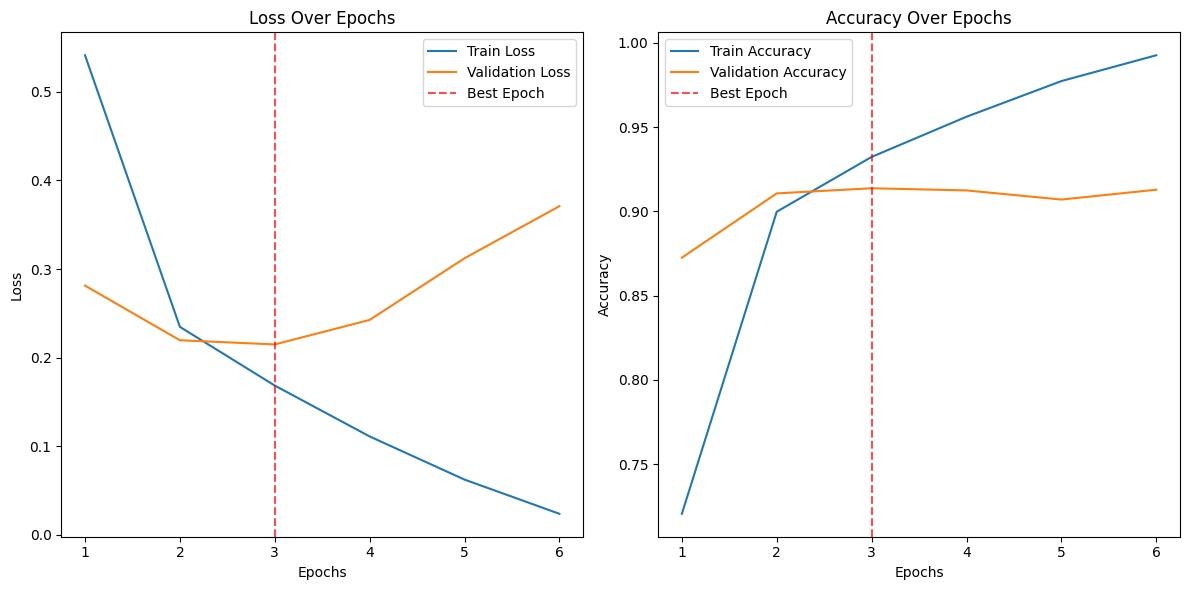

In [25]:
def plot_results(
    train_losses, val_losses, train_accuracies, val_accuracies, last_epoch
):

    epochs = range(1, len(train_losses) + 1)

    # Loss Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.axvline(
        x=last_epoch + 1,
        color="r",
        linestyle="--",
        label=f"Best Epoch",
        alpha=0.7,
    )
    plt.xticks(range(1, len(epochs) + 1))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.axvline(
        x=last_epoch + 1,
        color="r",
        linestyle="--",
        label=f"Best Epoch",
        alpha=0.7,
    )
    plt.xticks(range(1, len(epochs) + 1))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    # Anzeigen
    plt.tight_layout()
    plt.show()


plot_results(train_losses, val_losses, train_accuracies, val_accuracies, last_epoch)

In [13]:
# Funktion zum Testen des Modells mit zusätzlichen Metriken
def evaluate_model(model, test_loader):
    model.eval()  # Setze das Modell in den Eval-Modus
    test_loss = 0.0
    test_labels = []
    test_preds = []

    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():  # Keine Gradientenberechnung für Test
        for batch in test_loader:
            tokens, labels = batch
            tokens, labels = tokens.to(device), labels.to(device)

            # Forward Pass
            outputs = model(tokens)
            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item()

            # Berechne Vorhersagen und füge sie zur Liste hinzu
            test_preds += (outputs.squeeze() > 0.5).cpu().numpy().tolist()
            test_labels += labels.cpu().numpy().tolist()

    # Berechne Metriken
    test_accuracy = accuracy_score(test_labels, test_preds)
    test_precision = precision_score(test_labels, test_preds)
    test_recall = recall_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds)

    # Ausgabe der Metriken
    print(f"Test Loss: {test_loss/len(test_loader):.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")

    return test_labels, test_preds


# Teste das Modell
test_labels, test_preds = evaluate_model(trained_model, test_loader)

Test Loss: 0.3831
Test Accuracy: 0.9075
Test Precision: 0.9380
Test Recall: 0.9254
Test F1-Score: 0.9317


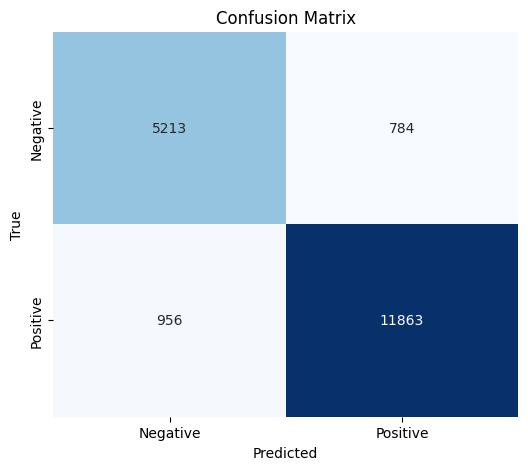

In [14]:
def plot_confusion_matrix(y_true, y_pred):

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        confusion_matrix(y_true, y_pred),
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Negative", "Positive"],
        yticklabels=["Negative", "Positive"],
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


plot_confusion_matrix(test_labels, test_preds)

In [18]:
# save the model
torch.save(trained_model.state_dict(), "../models/gru_classifier.pth")

### Results

**Hardware Specs:**
- CPU: AMD Ryzen 7 3700X 8-Core
- GPU: Nvidia GeForce RTX 3060 Ti
- RAM: 48GB
- OS: Linux Mint 22.1

**Training Results**

| Device | GRULayers | Dropout | EmbeddingDim | HiddenDim | VocabSize |     LR | Epoch | time/Epoch | TestAcc    | TestF1     |
| ------ | --------: | ------: | -----------: | --------: | --------: | -----: | ----: | ---------- | ---------- | ---------- |
| CPU    |         1 |       0 |          128 |       256 |     8.000 |  0.001 |     5 | 03:41      | ?          | ?          |
| Cuda   |         1 |       0 |          128 |       128 |     4.000 |  0.001 |     5 | 00:20      | 0.9096     | 0.9337     |
| Cuda   |         1 |       0 |          128 |       256 |     4.000 |  0.001 |     3 | 00:28      | **0.9110** | **0.9347** |
| Cuda   |         1 |       0 |          128 |       256 |     8.000 |  0.001 |    13 | 00:28      | 0.9019     | 0.9273     |
| Cuda   |         1 |       0 |          128 |       512 |     4.000 |  0.001 |    12 | 00:37      | 0.9013     | 0.9271     |
| Cuda   |         1 |       0 |          256 |       256 |     8.000 |  0.001 |    10 | 00:28      | 0.9051     | 0.9296     |
| Cuda   |         1 |       0 |          512 |       256 |     4.000 |  0.001 |    10 | 00:29      | 0.8897     | 0.9175     |
| Cuda   |         1 |       0 |          512 |       256 |    17.000 |  0.001 |     5 | 00:29      | 0.8781     | 0.9063     |
| Cuda   |         1 |       0 |          512 |       256 |    17.000 | 0.0001 |     5 | 00:29      | 0.8929     | 0.9190     |
| Cuda   |         1 |       0 |          512 |      1024 |     4.000 |  0.001 |     8 | 01:17      | 0.9022     | 0.9275     |
| Cuda   |         2 |     0.3 |          128 |       256 |     4.000 |  0.001 |     9 | 00:37      | 0.8875     | 0.9151     |
| Cuda   |         2 |     0.3 |          128 |       512 |     4.000 |  0.001 |     9 | 00:55      | 0.8915     | 0.9210     |
| Cuda   |         2 |     0.3 |          256 |       512 |     4.000 |  0.001 |    10 | 00:56      | 0.8992     | 0.9260     |
| Cuda   |         2 |     0.5 |          256 |      1024 |     4.000 |  0.001 |     4 | 02:13      | 0.8542     | 0.8855     |
| Cuda   |         2 |     0.5 |          512 |      1024 |     4.000 |  0.001 |     7 | 02:18      | 0.9103     | 0.9340     |